# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

2024-04-14 17:51:05.043267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
            - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    # density of multivariate normal distribution is e.g. here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [4]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

In [5]:
np.random.seed(123)

In [6]:
mu1 = np.array([0.2, 0.2, 0.2, 0, 0])
ro1 = 0.1
Sigma1 = np.array([[1, ro1, ro1, ro1, ro1],
                    [ro1, 1, ro1, ro1, ro1],
                    [ro1, ro1, 1, ro1, ro1],
                    [ro1, ro1, ro1, 1, ro1],
                    [ro1, ro1, ro1, ro1, 1]])

In [7]:
mu2 = np.array([0, 0, 0.2, 0.2, 0.2])
ro2 = -0.2
Sigma2 = np.array([[1, ro2, ro2, ro2, ro2],
                   [ro2, 1, ro2, ro2, ro2],
                   [ro2, ro2, 1, ro2, ro2],
                   [ro2, ro2, ro2, 1, ro2],
                   [ro2, ro2, ro2, ro2, 1]])

In [8]:
X = np.concatenate(
    [np.random.multivariate_normal(mu1, Sigma1, size=10000), 
     np.random.multivariate_normal(mu2, Sigma2, size=10000)]
)
Y = np.concatenate([1.0 * np.ones(10000), 0.0 * np.zeros(10000)])

In [9]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    first_term = np.sum(t * y) / n1
    second_term = np.log(np.sum(np.exp(t) * (1 - y)) / n2)
    return first_term - second_term

In [10]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042573

In [11]:
DV_fun(Y, T_opt(X, mu1, mu2, Sigma1, Sigma2))

2.0462300003059717

### c)

In [12]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [13]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

2024-04-14 17:51:08.922977: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [15]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0113 - val_loss: -0.0189
Epoch 2/100
15/15 [==============================] - 0s 29ms/step - loss: -0.0272 - val_loss: -0.0469
Epoch 3/100
15/15 [==============================] - 0s 23ms/step - loss: -0.0503 - val_loss: -0.0631
Epoch 4/100
15/15 [==============================] - 0s 20ms/step - loss: -0.0640 - val_loss: -0.0732
Epoch 5/100
15/15 [==============================] - 0s 17ms/step - loss: -0.0734 - val_loss: -0.0795
Epoch 6/100
15/15 [==============================] - 0s 17ms/step - loss: -0.0792 - val_loss: -0.0839
Epoch 7/100
15/15 [==============================] - 0s 17ms/step - loss: -0.0848 - val_loss: -0.0873
Epoch 8/100
15/15 [==============================] - 0s 18ms/step - loss: -0.0886 - val_loss: -0.0902
Epoch 9/100
15/15 [==============================] - 0s 21ms/step - loss: -0.0927 - val_loss: -0.0929
Epoch 10/100
15/15 [==============================] - 1s 43ms/step - loss: -0.0958 

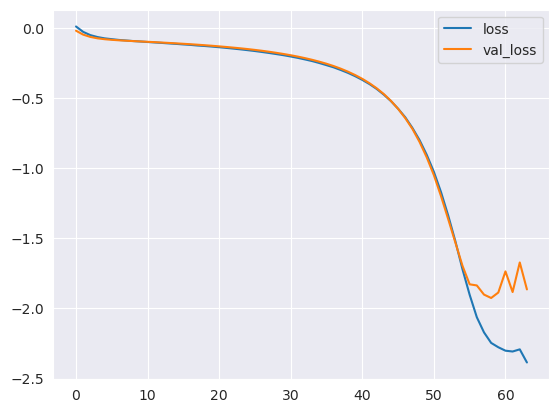

In [16]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### e)

In [17]:
t_x_pred = model.predict(X)[:, 0]

625/625 [==============================] - 2s 3ms/step


In [18]:
t_x_opt = T_opt(X, mu1, mu2, Sigma1, Sigma2)

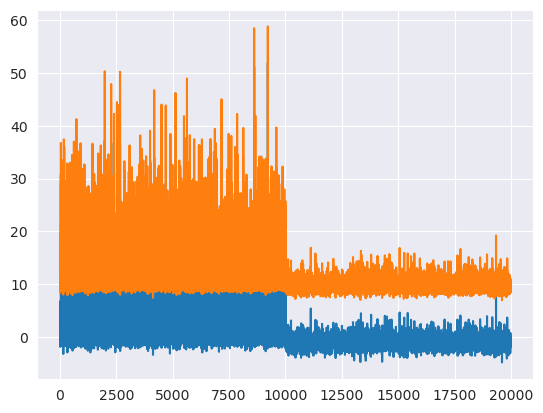

In [19]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

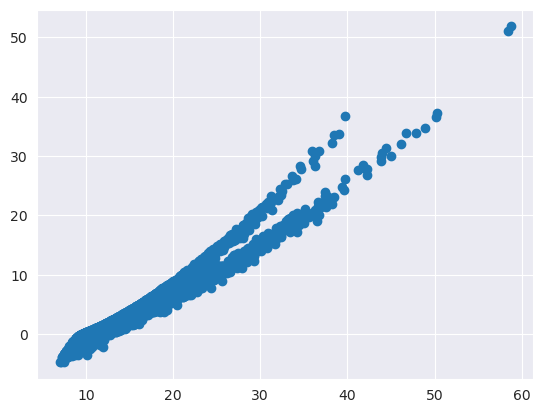

In [20]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [21]:
DV_fun(Y, t_x_pred)

1.9558496395587586

In [22]:
DV_fun(Y, t_x_opt)

2.0462300003059717

In [23]:
# new data
np.random.seed(42)
X_new = np.concatenate(
    [np.random.multivariate_normal(mu1, Sigma1, size=10000), 
     np.random.multivariate_normal(mu2, Sigma2, size=10000)]
)
Y_new = np.concatenate([1.0 * np.ones(10000), 0.0 * np.zeros(10000)])

t_x_pred_new = model.predict(X_new)[:, 0]

DV_fun(Y, t_x_pred_new), DV_fun(Y, t_x_opt)

625/625 [==============================] - 2s 3ms/step


(2.0690763831403434, 2.0462300003059717)

### f)

In [24]:
def NWJ_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true)) / n1
    second_term = (
            tf.math.reduce_sum(
                tf.math.multiply(
                    tf.math.exp(tf.subtract(T_x, tf.convert_to_tensor(1.0))),
                    tf.subtract(tf.convert_to_tensor(1.0), y_true),
                )
            )
            / n2
    )
    return -(first_term - second_term)

In [25]:
def NWJ_fun(y, t):
    return np.mean(t[y == 1]) - np.mean(np.exp(t[y == 0] - 1))

In [27]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
# layer_out = Dense(125, activation='tanh')(layer_out)
# layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss = NWJ_loss)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [29]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 1s 28ms/step - loss: 0.2664 - val_loss: 0.0449
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: -0.0265 - val_loss: -0.0601
Epoch 3/100
15/15 [==============================] - 0s 18ms/step - loss: -0.0620 - val_loss: -0.0717
Epoch 4/100
15/15 [==============================] - 0s 18ms/step - loss: -0.0794 - val_loss: -0.0845
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: -0.0884 - val_loss: -0.0931
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: -0.0983 - val_loss: -0.1020
Epoch 7/100
15/15 [==============================] - 0s 17ms/step - loss: -0.1083 - val_loss: -0.1124
Epoch 8/100
15/15 [==============================] - 0s 17ms/step - loss: -0.1195 - val_loss: -0.1233
Epoch 9/100
15/15 [==============================] - 0s 14ms/step - loss: -0.1312 - val_loss: -0.1350
Epoch 10/100
15/15 [==============================] - 0s 13ms/step - loss: -0.1447 -

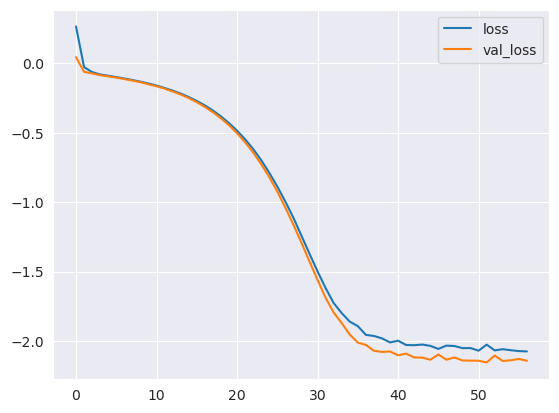

In [30]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

625/625 [==============================] - 2s 3ms/step


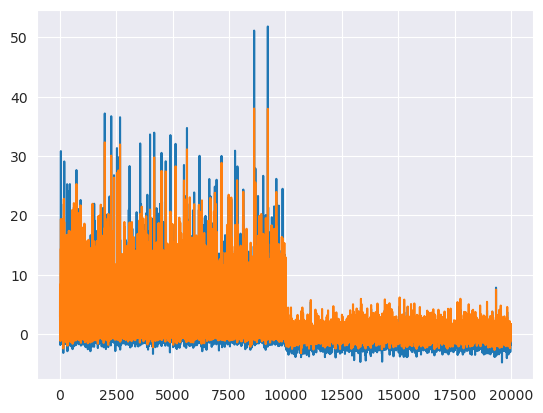

In [31]:
t_x_pred = model.predict(X)[:, 0]
t_x_opt = T_opt(X, mu1, mu2, Sigma1, Sigma2)

plt.plot(t_x_opt)
plt.plot(t_x_pred)
plt.show()

In [32]:
NWJ_fun(Y, t_x_pred), NWJ_fun(Y, t_x_opt)

(2.0995107, 1.7473387277077386)

In [33]:
t_x_pred = model.predict(X_new)[:, 0]
t_x_opt = T_opt(X_new, mu1, mu2, Sigma1, Sigma2)

NWJ_fun(Y_new, t_x_pred), NWJ_fun(Y_new, t_x_opt)

625/625 [==============================] - 1s 2ms/step


(2.0597851, 1.9293933483299632)